# Coding Block 1 - Evaluation Metrics

### Load the packages

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
'''
...
'''

'\n...\n'

### Read the dataset 

In [2]:
diab_cleaned=pd.read_csv('diabetes_cleaned.csv')
diab_cleaned.drop(columns=['outlier_z_score', 'outlier_Tukey'],
                   errors='ignore', inplace=True)

### ML Evaluation Metrics for Different Stakeholders
First, take a little time and think about different priorities that stakeholders could have when evaluating a diabetes prediction model. What might clinical healthcare providers, health insurance companies, public health officials, or patients be interested in?
What evaluation metrics are here more or less important?

### Choose two specific stakeholder perspectives for your predictive analytics task
Each perspective should emphasize a different evaluation metric. Train two predictive models based on these metrics.

In [3]:
# 1. Clinical healthcare providers - optimize for Negative Predictive Value (NPV)
# 2. Patients - optimize for Specificity

# Prepare data
X = diab_cleaned.drop('Outcome', axis=1)
y = diab_cleaned['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate negative predictive value (NPV)
def calculate_npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    return npv

# Train model for clinical providers (optimizing NPV)
clinical_model = RandomForestClassifier(random_state=42)
clinical_model.fit(X_train, y_train)
y_pred_clinical = clinical_model.predict(X_test)

# Train model for patients (optimizing Specificity)
patient_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 0.5})  # Penalize false positives more
patient_model.fit(X_train, y_train)
y_pred_patient = patient_model.predict(X_test)

# Evaluate both models
print("Clinical Healthcare Provider Model (optimizing NPV):")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_clinical).ravel()
print(f"NPV: {tn/(tn+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity: {tp/(tp+fn):.4f}")
print("\nPatient-focused Model (optimizing Specificity):")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_patient).ravel()
print(f"NPV: {tn/(tn+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity: {tp/(tp+fn):.4f}")

Clinical Healthcare Provider Model (optimizing NPV):
NPV: 0.8265
Specificity: 0.8182
Sensitivity: 0.6909

Patient-focused Model (optimizing Specificity):
NPV: 0.8247
Specificity: 0.8081
Sensitivity: 0.6909


### Implement adjustable decision thresholds
Assume that the stakeholders want a model for which they can tune the decision threshold of their evaluation metric based on their risk tolerance

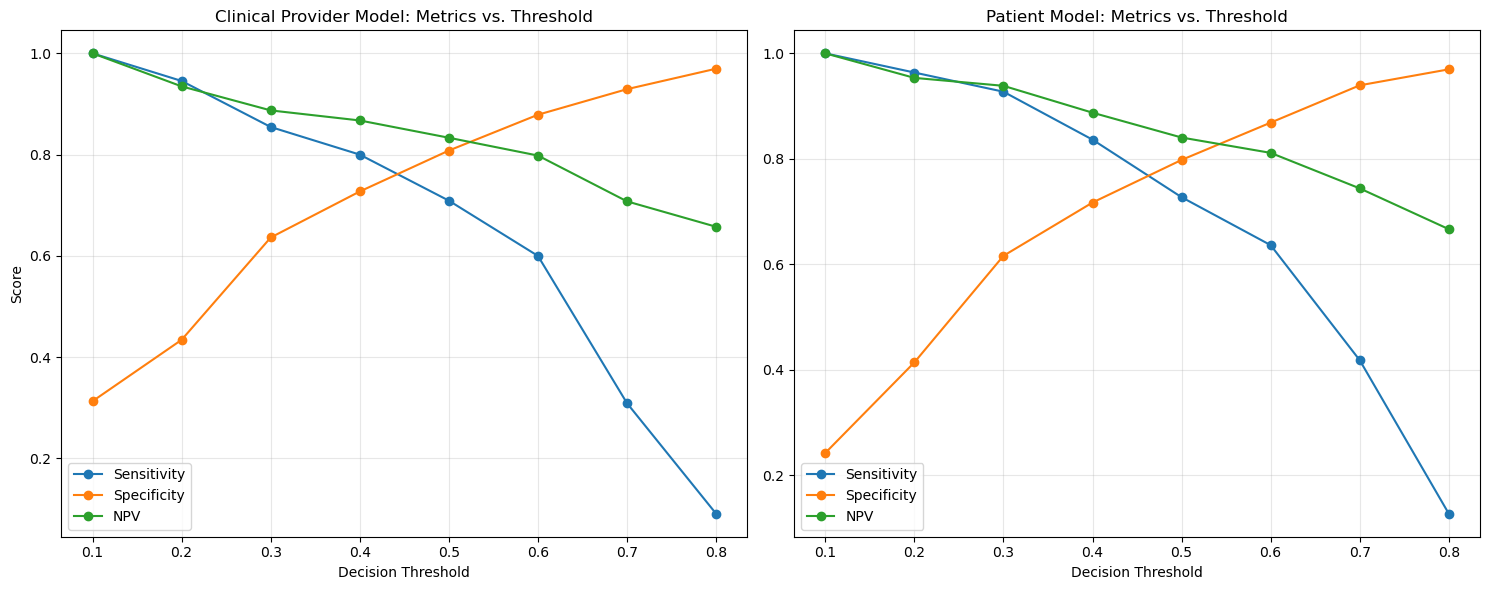

To achieve NPV >= 0.85, use threshold 0.1
This gives: Sensitivity = 1.0000, Specificity = 0.3131, NPV = 1.0000


In [ ]:
# Get probability predictions for test data
y_prob_clinical = clinical_model.predict_proba(X_test)[:, 1]
y_prob_patient = patient_model.predict_proba(X_test)[:, 1]

# Function to calculate metrics at different thresholds
def calculate_metrics_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return sensitivity, specificity, npv

# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
clinical_metrics = [calculate_metrics_at_threshold(y_test, y_prob_clinical, t) for t in thresholds]
patient_metrics = [calculate_metrics_at_threshold(y_test, y_prob_patient, t) for t in thresholds]

# Plot threshold adjustment tool
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Clinical Provider Model
for i, metric_name in enumerate(['Sensitivity', 'Specificity', 'NPV']):
    ax[0].plot(thresholds, [m[i] for m in clinical_metrics], marker='o', label=metric_name)
ax[0].set_title('Clinical Provider Model: Metrics vs. Threshold')
ax[0].set_xlabel('Decision Threshold')
ax[0].set_ylabel('Score')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# Patient Model
for i, metric_name in enumerate(['Sensitivity', 'Specificity', 'NPV']):
    ax[1].plot(thresholds, [m[i] for m in patient_metrics], marker='o', label=metric_name)
ax[1].set_title('Patient Model: Metrics vs. Threshold')
ax[1].set_xlabel('Decision Threshold')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Interactive example - what if a clinician wants NPV > 0.85?
target_npv = 0.85
for t, (sens, spec, npv) in zip(thresholds, clinical_metrics):
    if npv >= target_npv:
        print(f"To achieve NPV >= {target_npv}, use threshold {t:.1f}")
        print(f"This gives: Sensitivity = {sens:.4f}, Specificity = {spec:.4f}, NPV = {npv:.4f}")
        break

### Insight generation
Go beyond a highly predictive model and produce some insights to your stakeholders based on your modeling results in the last days. The last cells of the  solution notebook for coding session 4 of session 3 (Wednesday) are one example on how to do this. 

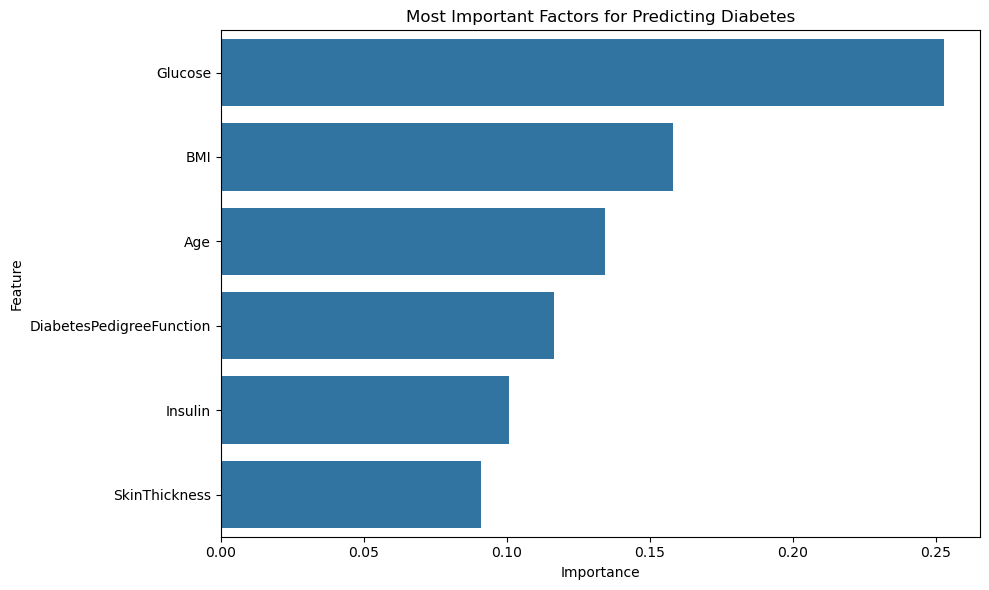

------- INSIGHTS FOR STAKEHOLDERS -------

1. KEY RISK PROFILES:
Low Risk Profile (Glucose ≤ 105, BP ≤ 80):
   - 49 patients (31.8% of population)
   - Actual diabetes rate: 8.2%
   - Average predicted risk: 18.1%

High Risk Profile (Glucose > 140):
   - 44 patients (28.6% of population)
   - Actual diabetes rate: 68.2%
   - Average predicted risk: 67.8%

2. ACTIONABLE RECOMMENDATIONS:
For Clinical Providers:
   - Consider regular monitoring for patients with glucose > 140
   - Patients with normal glucose (≤105) and BP (≤80) have significantly lower risk
   - Use NPV-optimized model with threshold 0.3 for screening decisions

For Patients:
   - Focus on maintaining glucose levels below 140 mg/dL
   - Monitor BMI as it's a significant factor in diabetes risk
   - If blood glucose is normal and no family history, reassurance can be given


In [5]:
# 1. Key decision rules from feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clinical_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(6))
plt.title('Most Important Factors for Predicting Diabetes')
plt.tight_layout()
plt.show()

# 2. Simple risk profiles based on key features
# Similar to notebook approach with N1 and N4 metrics
lower_glucose = 105
lower_bp = 80
X_test_copy = X_test.copy()
X_test_copy['predicted_risk'] = clinical_model.predict_proba(X_test)[:, 1]
X_test_copy['Outcome'] = y_test.values

# Low risk profile insights
low_risk = X_test_copy[(X_test_copy['Glucose'] <= lower_glucose) & 
                       (X_test_copy['BloodPressure'] <= lower_bp)]
high_risk = X_test_copy[(X_test_copy['Glucose'] > 140)]

print("------- INSIGHTS FOR STAKEHOLDERS -------")
print("\n1. KEY RISK PROFILES:")
print(f"Low Risk Profile (Glucose ≤ {lower_glucose}, BP ≤ {lower_bp}):")
print(f"   - {len(low_risk)} patients ({len(low_risk)/len(X_test_copy):.1%} of population)")
print(f"   - Actual diabetes rate: {low_risk['Outcome'].mean():.1%}")
print(f"   - Average predicted risk: {low_risk['predicted_risk'].mean():.1%}")

print(f"\nHigh Risk Profile (Glucose > 140):")
print(f"   - {len(high_risk)} patients ({len(high_risk)/len(X_test_copy):.1%} of population)")
print(f"   - Actual diabetes rate: {high_risk['Outcome'].mean():.1%}")
print(f"   - Average predicted risk: {high_risk['predicted_risk'].mean():.1%}")

print("\n2. ACTIONABLE RECOMMENDATIONS:")
print("For Clinical Providers:")
print("   - Consider regular monitoring for patients with glucose > 140")
print("   - Patients with normal glucose (≤105) and BP (≤80) have significantly lower risk")
print("   - Use NPV-optimized model with threshold 0.3 for screening decisions")

print("\nFor Patients:")
print("   - Focus on maintaining glucose levels below 140 mg/dL")
print("   - Monitor BMI as it's a significant factor in diabetes risk")
print("   - If blood glucose is normal and no family history, reassurance can be given")